In [1]:
import os
import pathlib
import random
import pandas as pd 

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from matplotlib import rcParams
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import *
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Concatenate

from tensorflow.python.ops.numpy_ops import np_config

import nengo
import nengo_dl

# 상수 설정
SAMPLE_RATE = 16000
CHUNK_SIZE  = 1664
TARGET_CHUNK_SIZE = 1664  # 목표로 하는 청크의 길이

EPOCHS      = 40
BATCH_SIZE  = 1
SEED        = 0


DATASET_PATH = '../../Data/Test_dataset/03/'
DATASET_PATH_0 = DATASET_PATH + 'train'
DATASET_PATH_1 = DATASET_PATH + 'test'


In [2]:
# 오디오 데이터의 차원을 줄이는 함수
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels


# MFCC 추출 함수
def get_mfcc(waveform, sr=SAMPLE_RATE, n_mfcc=13, target_shape=(8, 13, 1)):
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)
    
    # STFT 계산
    stft = tf.signal.stft(waveform, frame_length=512, frame_step=128, fft_length=512)
    spectrogram = tf.abs(stft)
    
    # 멜 필터를 적용하여 멜 스펙트로그램 생성
    num_spectrogram_bins = stft.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz, upper_edge_hertz)
    mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    # 로그 멜 스펙트로그램 계산
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)[..., :n_mfcc]
    mfccs = mfccs[..., tf.newaxis]

    # MFCC 크기 조정
    # mfccs = resize_mfcc_tf(mfccs, target_shape)
    
    return mfccs


def resize_mfcc_tf(mfccs, target_shape):
    mfcc_shape = tf.shape(mfccs)
    pad_shape = tf.convert_to_tensor([target_shape[0], target_shape[1]]) - mfcc_shape[1:3]
    paddings = tf.convert_to_tensor([[0, 0], [0, pad_shape[0]], [0, pad_shape[1]], [0, 0]])
    mfccs = tf.pad(mfccs, paddings, "CONSTANT")
    return mfccs


# MFCC 시각화 함수
def plot_mfcc(mfcc, ax):
    if len(mfcc.shape) > 2:
        assert len(mfcc.shape) == 3
        mfcc = np.squeeze(mfcc, axis=-1)
    log_spec = np.log(mfcc.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    x = np.linspace(0, np.size(mfcc), num=width, dtype=int)
    y = range(height)
    ax.pcolormesh(x, y, log_spec)

    
# 데이터셋에 MFCC 적용하는 함수
def make_mfcc_ds(ds):
    print("make_mfcc_ds type(ds)", type(ds))
    print("make_mfcc_ds", ds)
    
    return ds.map(lambda audio, label: (get_mfcc(audio), label), num_parallel_calls=tf.data.AUTOTUNE)

#  오디오 청크를 처리하는 함수
def process_audio_chunks(audio_path, target_shape=(8, 13, 1)):
    raw_audio = tf.io.read_file(str(audio_path))
    waveform, sr = tf.audio.decode_wav(raw_audio, desired_channels=1, desired_samples=SAMPLE_RATE)
    waveform = tf.squeeze(waveform, axis=-1)
    
    # 청크 생성
    num_samples = tf.shape(waveform)[0]
    num_chunks = (num_samples + CHUNK_SIZE - 1) // CHUNK_SIZE
    pad_len = num_chunks * CHUNK_SIZE - num_samples
    waveform = tf.concat([waveform, tf.zeros(pad_len, dtype=tf.float32)], 0)
    
    waveform_chunks = tf.reshape(waveform, [num_chunks, CHUNK_SIZE])
    
    # MFCC 추출
    mfccs = tf.map_fn(lambda x: get_mfcc(x, target_shape=target_shape), waveform_chunks, dtype=tf.float32)
    
    return mfccs, waveform
    

In [3]:
# 시드 설정
tf.random.set_seed(SEED)
np.random.seed(SEED)
rcParams.update({'figure.autolayout': True})

In [4]:
data_dir = pathlib.Path(DATASET_PATH_0)
if not data_dir.exists():
    print("Dataset Not Exists")
    exit()

labels_dir = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Labels:', labels_dir)

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=pathlib.Path(DATASET_PATH_0),
    batch_size=256,
    seed=0,
    output_sequence_length=CHUNK_SIZE,
    subset='both',
    validation_split=0.3
)

test_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=pathlib.Path(DATASET_PATH_1),
    batch_size=256,
    seed=0,
    output_sequence_length=CHUNK_SIZE,
    subset=None,
    validation_split=None
)

label_names = np.array(train_ds.class_names)
print("label names:", label_names)

train_ds.element_spec

for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)

# label_names[[0,1]]

train_mfcc_ds = make_mfcc_ds(train_ds.map(squeeze, tf.data.AUTOTUNE))
val_mfcc_ds   = make_mfcc_ds(val_ds.map(squeeze, tf.data.AUTOTUNE))
test_mfcc_ds  = make_mfcc_ds(test_ds.map(squeeze, tf.data.AUTOTUNE))

Labels: ['_abnormal' '_normal']
Found 12392 files belonging to 2 classes.
Using 8675 files for training.
Using 3717 files for validation.
Found 1361 files belonging to 2 classes.
label names: ['_abnormal' '_normal']
(256, 1664, 1)
(256,)
make_mfcc_ds type(ds) <class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>
make_mfcc_ds <ParallelMapDataset element_spec=(TensorSpec(shape=(None, 1664), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
make_mfcc_ds type(ds) <class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>
make_mfcc_ds <ParallelMapDataset element_spec=(TensorSpec(shape=(None, 1664), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
make_mfcc_ds type(ds) <class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>
make_mfcc_ds <ParallelMapDataset element_spec=(TensorSpec(shape=(None, 1664), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


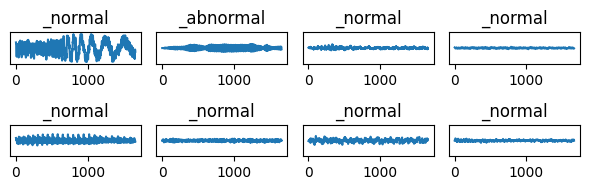

<BatchDataset element_spec=(TensorSpec(shape=(None, 1664, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
(TensorSpec(shape=(None, 10, 13, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


C:\Users\mosfet\AppData\Local\Temp\ipykernel_22924\4247221664.py:46: RuntimeWarning: invalid value encountered in log
  log_spec = np.log(mfcc.T + np.finfo(float).eps)


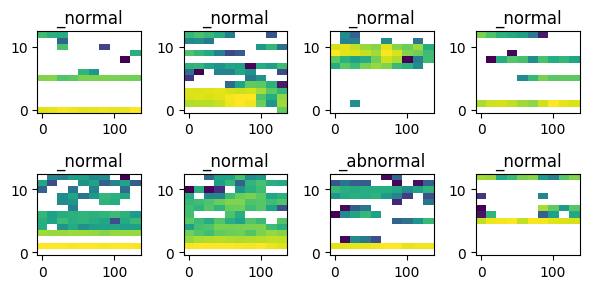

In [5]:
# 오디오 파형 시각화
rows = 2
cols = 4
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(6, 2))

for i in range(n):
    if(i >= n):
        break
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(example_audio[i].numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label_names[example_labels[i]]
    ax.set_title(label)
    ax.set_ylim([-1.1,1.1])
    ax.axes.yaxis.set_visible(False)

plt.show()
print(train_ds)
print(train_mfcc_ds.element_spec)

# MFCC 시각화
for example_mfcc, example_mfcc_labels in train_mfcc_ds.take(1):
    break

fig, axes = plt.subplots(rows, cols, figsize=(6, 3))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_mfcc(example_mfcc[i].numpy(), ax)
    ax.set_title(labels_dir[example_mfcc_labels[i].numpy()])

plt.show()

In [6]:
def leNetcustom(input_shape, num_labels, norm_layer):
    # 입력 레이어 정의
    inp = tf.keras.Input(shape=input_shape)
    resized = tf.keras.layers.Resizing(16, 16)(inp)

    # 정규화 레이어 추가
    normalized = norm_layer(resized)

    # 합성곱 및 풀링 레이어 추가
    conv0 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.nn.relu)(normalized)
    pool0 = tf.keras.layers.MaxPooling2D((2, 2))(conv0)
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.nn.relu)(pool0)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    # 출력을 펼치고 밀집 레이어 추가
    flatten = tf.keras.layers.Flatten()(pool1)
    dense0 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(flatten)
    dropout = tf.keras.layers.Dropout(0.25)(dense0)

    # 출력 레이어 정의
    out = tf.keras.layers.Dense(num_labels, activation=tf.nn.softmax)(dropout)

    # 모델 생성
    model = tf.keras.Model(inputs=inp, outputs=out)
    
    print(model.layers[3])
    print(type(model.layers[3]))
    
    return model, inp, out, conv0

In [7]:
# 데이터셋 캐시 및 프리페치 설정
train_mfcc_ds = pd.DataFrame(train_mfcc_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)).to_numpy()
val_mfcc_ds = pd.DataFrame(val_mfcc_ds.cache().prefetch(tf.data.AUTOTUNE)).to_numpy()
test_mfcc_ds = pd.DataFrame(test_mfcc_ds.cache().prefetch(tf.data.AUTOTUNE)).to_numpy()

print(example_mfcc.shape)

# 입력 형태 설정
input_shape = example_mfcc.shape[1:]
print('Input shape:', input_shape)
    
# 라벨 개수 설정 및 정규화 레이어 설정
num_labels = len(labels_dir)
norm_layer = tf.keras.layers.Normalization()

# 모델 생성
model, inp, dense, conv0 = leNetcustom(input_shape, num_labels, norm_layer)
model.summary()

(256, 10, 13, 1)
Input shape: (10, 13, 1)
<class 'keras.layers.convolutional.conv2d.Conv2D'>
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 13, 1)]       0         
                                                                 
 resizing (Resizing)         (None, 16, 16, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 16, 16, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 16)         0         
 )                                                               
                                  

In [8]:
# 데이터셋에 시간 축 추가
def add_time_axis(input_data, output_data):
    input_data = input_data[:, None, :]
    output_data = output_data[:, None]
    return input_data, output_data


def reshape_tensor(mfcc_ds):
    # tf.Tensor로 변환
    for i in range(mfcc_ds.shape[0]):
        mfcc_ds[i][0] = tf.convert_to_tensor(mfcc_ds[i][0], dtype=tf.float32)
        mfcc_ds[i][1] = tf.convert_to_tensor(mfcc_ds[i][1], dtype=tf.int32)

    # 모든 배치에 대해 입력 데이터와 출력 데이터의 형태 변환
    transformed_inputs = []
    transformed_outputs = []

    for i in range(mfcc_ds.shape[0]):
        # 입력 데이터 형태 변경 (256, 8, 13, 1) -> (256, 104)
        input_data = np.transpose(mfcc_ds[i][0], (0, 2, 1, 3))
        input_data = tf.reshape(input_data, (input_data.shape[0], -1))

        # 출력 데이터 형태 변경 (256,) -> (256, 1)
        output_data = tf.reshape(mfcc_ds[i][1], (mfcc_ds[i][1].shape[0], 1))

        transformed_inputs.append(input_data)
        transformed_outputs.append(output_data)

    # tf.data.Dataset으로 변환
    dataset = tf.data.Dataset.from_tensor_slices(
        (tf.concat(transformed_inputs, axis=0), 
         tf.concat(transformed_outputs, axis=0))
        ).shuffle(buffer_size=1024).batch(256)
    
    return dataset
    

def dataset2batch(dataset):
    # 데이터셋에 시간 축 추가
    dataset.map(add_time_axis)
    
    for batch_inputs, batch_outputs in dataset.take(1):
        # print("Batch inputs shape:", batch_inputs.shape)
        # print("Batch outputs shape:", batch_outputs.shape)
        continue

    return pd.DataFrame(batch_inputs).to_numpy(), pd.DataFrame(batch_outputs).to_numpy()

In [9]:
train_dataset = reshape_tensor(train_mfcc_ds)
val_dataset = reshape_tensor(val_mfcc_ds)
test_dataset = reshape_tensor(test_mfcc_ds)

train_batch_inputs, train_batch_outputs = dataset2batch(train_dataset)
val_batch_inputs, val_batch_outputs = dataset2batch(val_dataset)
test_batch_inputs, test_batch_outputs = dataset2batch(test_dataset)

# 차원 추가
test_batch_inputs = np.expand_dims(test_batch_inputs, axis=1)
test_batch_outputs = np.expand_dims(test_batch_outputs, axis=1)

In [10]:
def run_network(
    batch_inputs,
    batch_outputs,
    activation,
    params_file="SAFE_lenetcustom",
    n_steps=10,
    scale_firing_rates=1,
    synapse=None,
    dt=0.001,
):
    n_test = batch_inputs.shape[0]

    # keras 모델을 nengo 네트워크로 변환
    nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=scale_firing_rates,
        synapse=synapse,
    )
    
    # 입력 및 출력 객체 가져오기
    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[dense]

    # 메모리를 절약하기 위해 일부 뉴런만 기록
    sample_neurons = np.linspace(
        0,
        np.prod(conv0.shape[1:]),  # 첫 번째 합성곱과 리사이징 레이어를 제외한 뉴런을 샘플링
        1000,
        endpoint=False,
        dtype=np.int32
    )

    with nengo_converter.net:
        conv0_probe = nengo.Probe(nengo_converter.layers[conv0][sample_neurons])
        # print("conv0_probe :", conv0_probe)
        
    # 일부 타임스텝에 대해 입력을 반복
    tiled_test_batch_inputs = np.tile(batch_inputs[:n_test], (1, n_steps, 1))

    # 시뮬레이션 속도를 높이기 위해 몇 가지 옵션 설정
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # 네트워크 빌드, 훈련된 가중치 로드, 테스트 이미지에서 추론 실행
    with nengo_dl.Simulator(nengo_converter.net, minibatch_size=1, progress_bar=False, dt=dt) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_batch_inputs})

    # 마지막 타임스텝에서 네트워크의 출력을 사용하여 테스트 데이터 정확도 계산
    predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    accuracy = (predictions == batch_outputs[:n_test, 0, 0]).mean()
    print(f"Test accuracy: {100 * accuracy:.2f}%")
    print("predictions", predictions)

    random_indices = random.sample(range(n_test), 2)

    for i in random_indices:
        plt.figure(figsize=(9, 3))
        plt.subplot(1, 3, 1)
        plt.title(f"Input {i} : {batch_outputs[i]}")
        plt.axis("off")
        plt.subplot(1, 3, 2)

        scaled_data = data[conv0_probe][i] * scale_firing_rates
        if isinstance(activation, nengo.SpikingRectifiedLinear):
            scaled_data *= 0.001
            rates = np.sum(scaled_data, axis=0) / (n_steps * nengo_sim.dt)
            plt.ylabel("Number of spikes")
        else:
            rates = scaled_data
            plt.ylabel("Firing rates (Hz)")

        plt.xlabel("Timestep")
        plt.title(
            f"Neural activities\n"
            f"(conv0 mean={rates.mean():.1f} Hz, "
            f"max={rates.max():.1f} Hz)"
        )
        plt.plot(scaled_data)
        plt.subplot(1, 3, 3)
        plt.title("Output predictions")
        plt.plot(tf.nn.softmax(data[nengo_output][i]))
        plt.legend(["Normal", "Abnormal"], loc="upper left")
        plt.xlabel("Timestep")
        plt.ylabel("Probability")
        plt.tight_layout()
        plt.show()

In [11]:
# NengoDL을 사용하여 TensorFlow Keras 모델을 Nengo 네트워크로 변환
converter = nengo_dl.Converter(model)

minibatch_size = 1
do_training = False

if do_training:
    sim = nengo_dl.Simulator(converter.net, minibatch_size=minibatch_size)
    sim.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )  
    # tf.data.Dataset을 사용하여 evaluate 수행
    for train_batch_inputs, train_batch_outputs in train_dataset.take(1):
        test_accuracy = sim.evaluate(train_batch_inputs, train_batch_outputs, verbose=1)["probe_accuracy"]
        print("Test accuracy:", test_accuracy)
    # 학습
    sim.fit(
        {converter.inputs[inp]:train_batch_inputs},
        {converter.outputs[dense]:train_batch_outputs}, 
        validation_data=(
            {converter.inputs[inp]:val_batch_inputs},
            {converter.outputs[dense]:val_batch_outputs}
        ),
        epochs=5,
    )
    # save the parameters to file
    sim.save_params("./models/SAFE-0620-1")
else:
    sim = nengo_dl.Simulator(converter.net, minibatch_size=minibatch_size)
    sim.load_params("./models/SAFE-0620-1")
    print("Loaded pretrained weights")

sim.close()

np_config.enable_numpy_behavior()
print("num of test data :", test_batch_inputs.shape[0])

|                     Building network (0%)                    | ETA:  --:--:--
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Optimizing graph: creating signals finished in 0:00:00
Optimization finished in 0:00:00
|#                        Constructing graph                          | 0:00:00


c:\Users\mosfet\AppData\Local\Programs\Python\Python310\lib\site-packages\nengo_dl\converter.py:324: UserWarning: Layer type Resizing does not have a registered converter. Falling back to TensorNode.
  warnings.warn(
c:\Users\mosfet\AppData\Local\Programs\Python\Python310\lib\site-packages\nengo_dl\converter.py:324: UserWarning: Layer type Normalization does not have a registered converter. Falling back to TensorNode.
  warnings.warn(
c:\Users\mosfet\AppData\Local\Programs\Python\Python310\lib\site-packages\nengo_dl\converter.py:324: UserWarning: Cannot convert max pooling layers to native Nengo objects; consider setting max_to_avg_pool=True to use average pooling instead. Falling back to TensorNode.
  warnings.warn(
c:\Users\mosfet\AppData\Local\Programs\Python\Python310\lib\site-packages\nengo_dl\converter.py:324: UserWarning: Layer type Dropout does not have a registered converter. Falling back to TensorNode.
  warnings.warn(
c:\Users\mosfet\AppData\Local\Programs\Python\Python310\l

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
| #                       Constructing graph                          | 0:00:00
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|######        Constructing graph: build stage (10%)             | ETA: 0:00:00
|##############Constructing graph: build stage (86%)####         | ETA: 0:00:00
Constructing graph: build stage finished in 0:00:00
|  #                      Constructing graph                          | 0:00:00
Construction finished in 0:00:00
Loaded pretrained weights
num of test data : 256


In [12]:
'''
    Spiking Neural Network (SNN) 시뮬레이션 결과를 플롯

    Parameters:
    - test_batch_outputs: 테스트 데이터의 레이블 (0, 1)을 포함하는 배열. 
    - data: 시뮬레이션 데이터를 포함하는 딕셔너리.
    - conv0_probe: 첫 번째 합성곱 레이어를 위한 프로브.
    - nengo_output: 네트워크 출력에 접근하기 위한 키.
    - scale_firing_rates: 발화율의 스케일링 계수.
    - activation: SNN에서 사용된 활성화 함수.
    - n_steps: 시뮬레이션 타임스텝 수.
    - nengo_sim: NengoDL 시뮬레이터 객체.
'''

'\n    Spiking Neural Network (SNN) 시뮬레이션 결과를 플롯\n\n    Parameters:\n    - test_batch_outputs: 테스트 데이터의 레이블 (0, 1)을 포함하는 배열. \n    - data: 시뮬레이션 데이터를 포함하는 딕셔너리.\n    - conv0_probe: 첫 번째 합성곱 레이어를 위한 프로브.\n    - nengo_output: 네트워크 출력에 접근하기 위한 키.\n    - scale_firing_rates: 발화율의 스케일링 계수.\n    - activation: SNN에서 사용된 활성화 함수.\n    - n_steps: 시뮬레이션 타임스텝 수.\n    - nengo_sim: NengoDL 시뮬레이터 객체.\n'

256/256 [==============================] - 5s 19ms/step
Test accuracy: 85.16%
predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


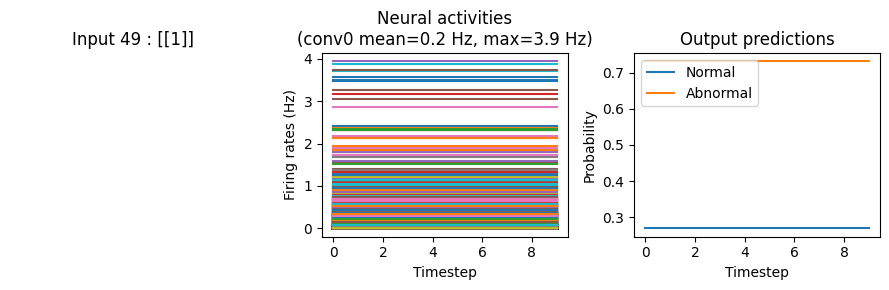

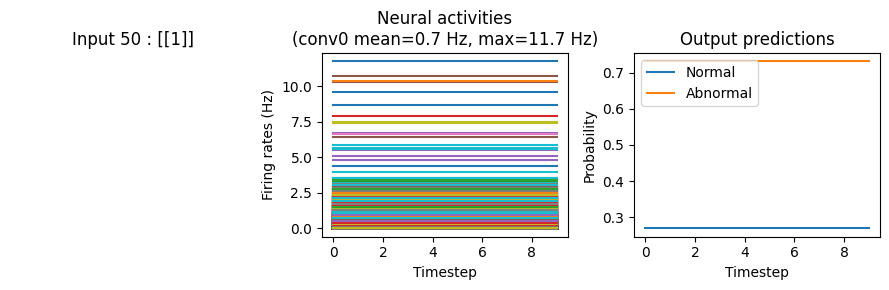

In [13]:
run_network(
    test_batch_inputs, 
    test_batch_outputs, 
    activation=nengo.RectifiedLinear(), 
    n_steps=10
)

256/256 [==============================] - 6s 21ms/step
Test accuracy: 80.08%
predictions [1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1]


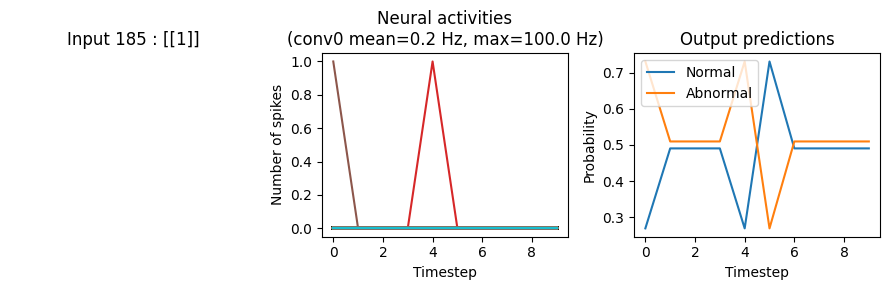

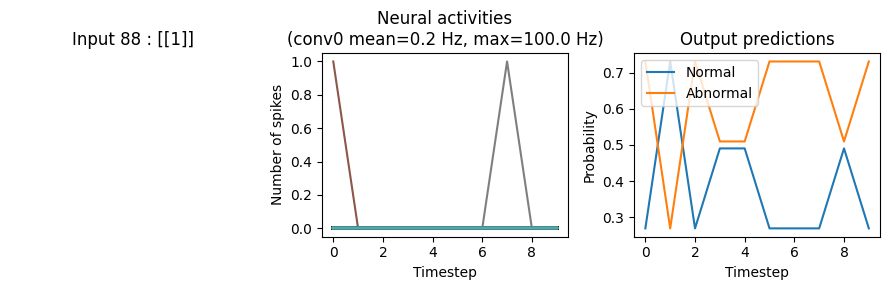

In [14]:
run_network(
    test_batch_inputs, 
    test_batch_outputs, 
    activation=nengo.SpikingRectifiedLinear()
)

Synapse=0.001
256/256 [==============================] - 29s 113ms/step
Test accuracy: 77.34%
predictions [0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1
 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]


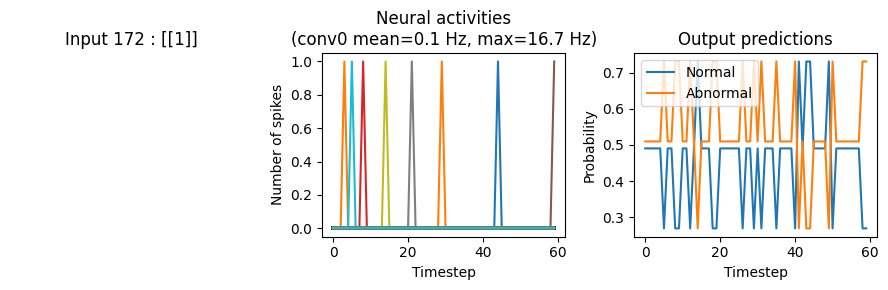

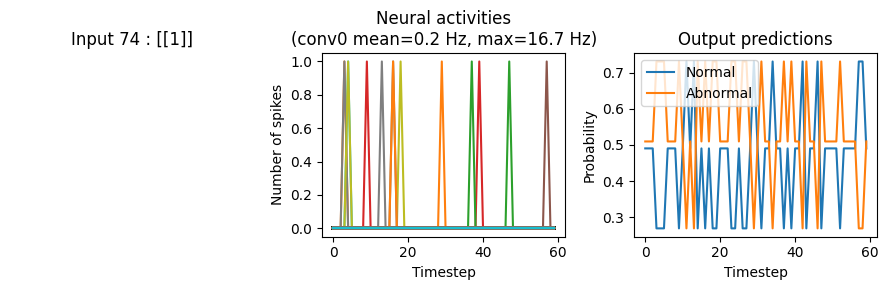

Synapse=0.005
256/256 [==============================] - 29s 110ms/step
Test accuracy: 76.17%
predictions [0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]


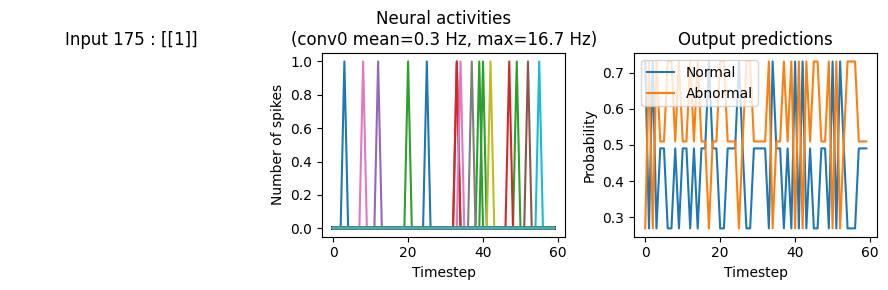

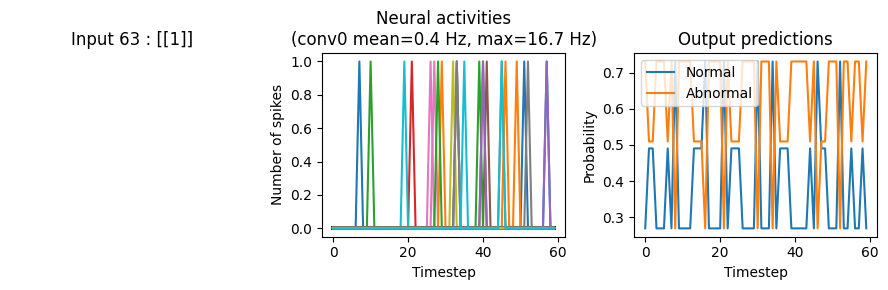

Synapse=0.010
256/256 [==============================] - 30s 115ms/step
Test accuracy: 79.69%
predictions [1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


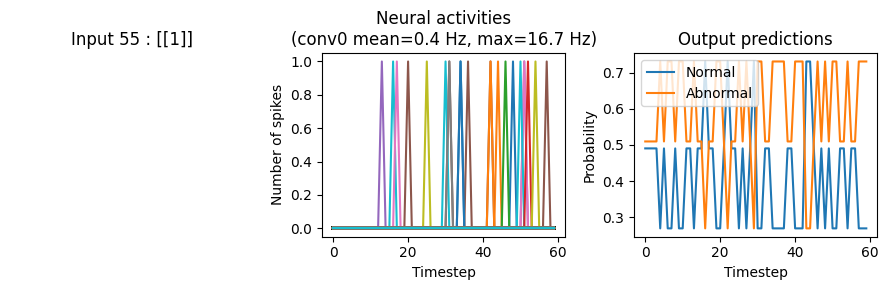

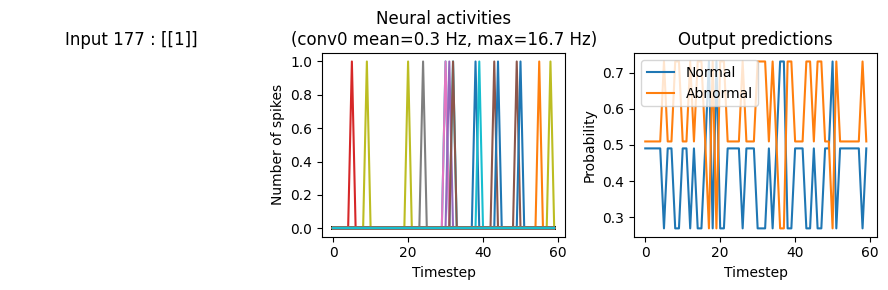

In [15]:
for s in [0.001, 0.005, 0.01]:
    print(f"Synapse={s:.3f}")
    run_network(
        test_batch_inputs, 
        test_batch_outputs,     
        activation=nengo.SpikingRectifiedLinear(),
        n_steps=60,
        synapse=s,
    )
    plt.show()

Scale=2
256/256 [==============================] - 5s 20ms/step
Test accuracy: 78.12%
predictions [0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


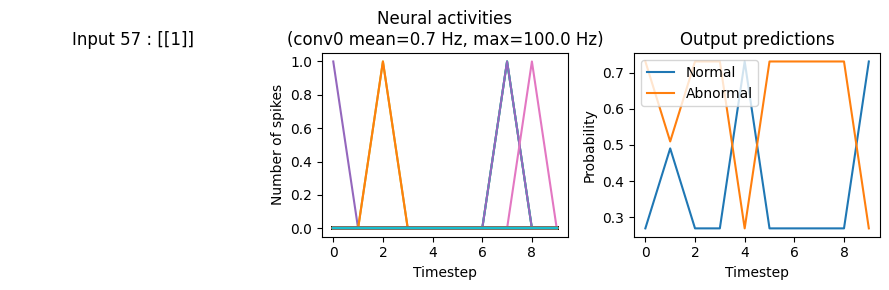

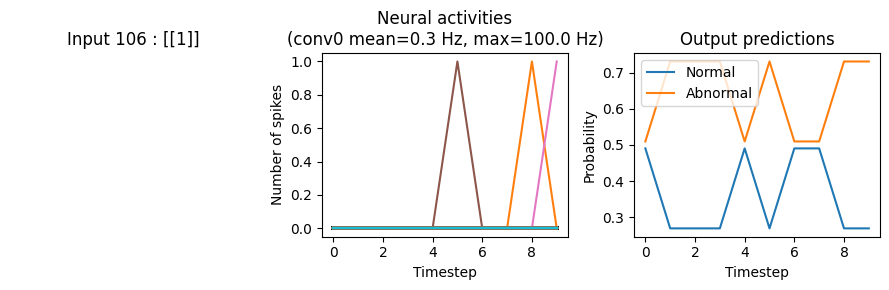

Scale=5
256/256 [==============================] - 6s 20ms/step
Test accuracy: 82.81%
predictions [1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]


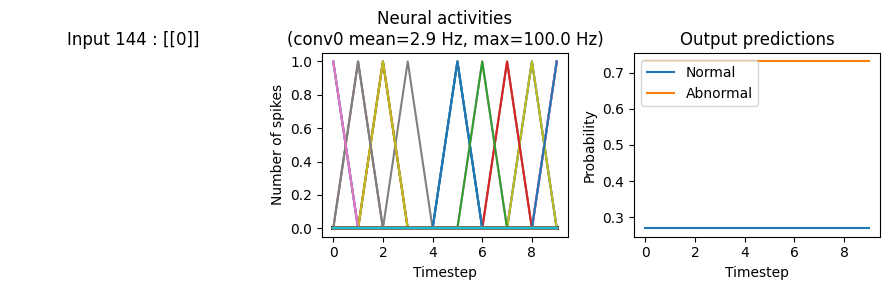

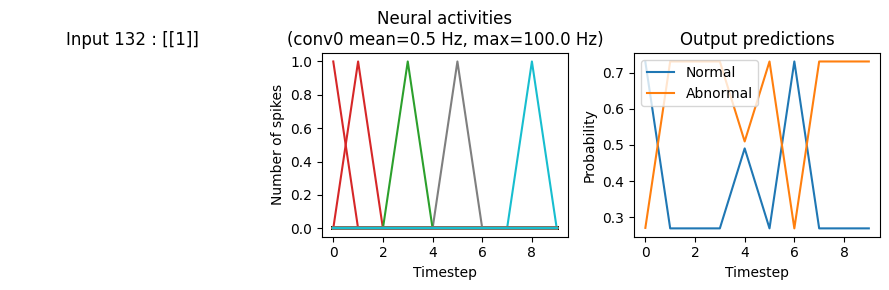

Scale=10
256/256 [==============================] - 5s 19ms/step
Test accuracy: 83.98%
predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


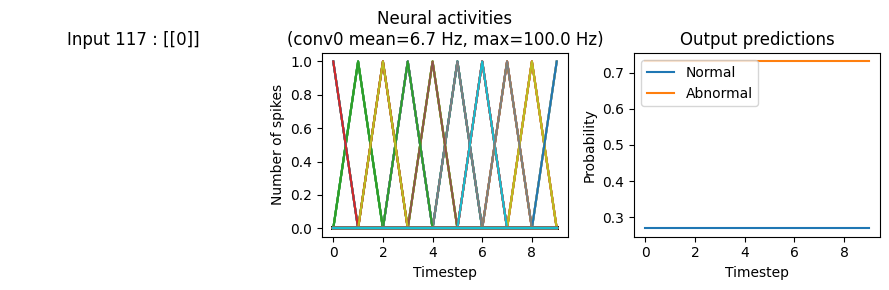

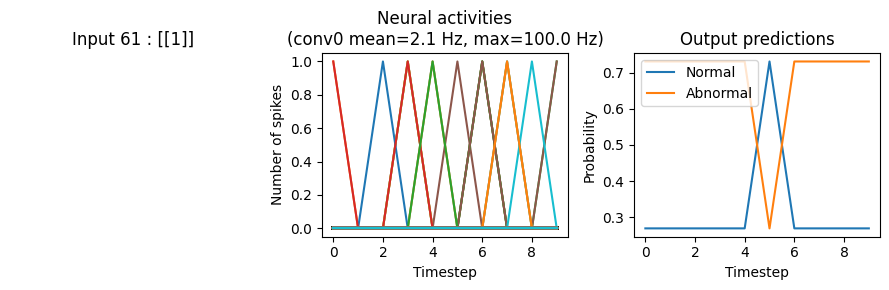

In [16]:
for scale in [2, 5, 10]:
    print(f"Scale={scale}")
    run_network(
        test_batch_inputs, 
        test_batch_outputs, 
        activation=nengo.SpikingRectifiedLinear(),
        scale_firing_rates=scale,
        synapse=0.01,
    )
    plt.show()

Scale=20
256/256 [==============================] - 6s 21ms/step
Test accuracy: 84.77%
predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


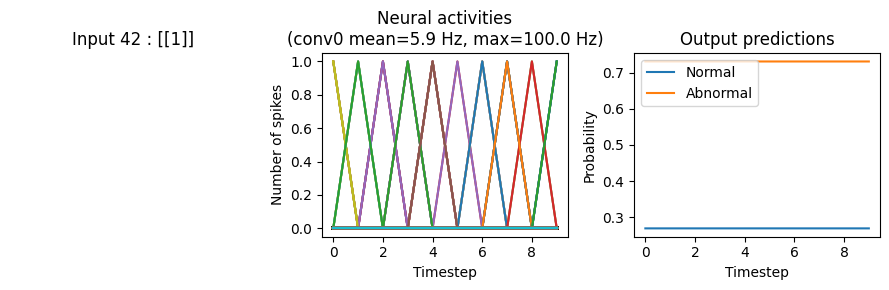

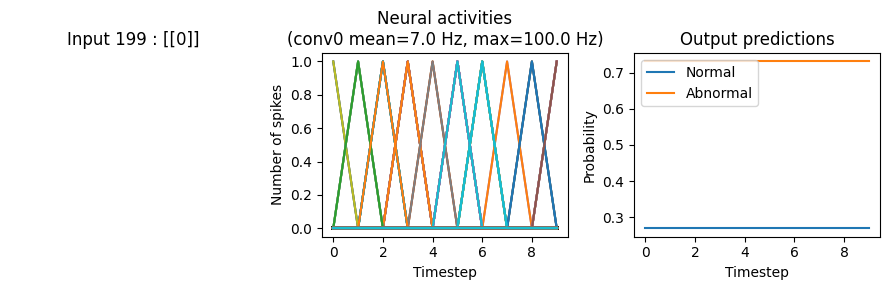

Scale=50
256/256 [==============================] - 5s 20ms/step
Test accuracy: 85.16%
predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


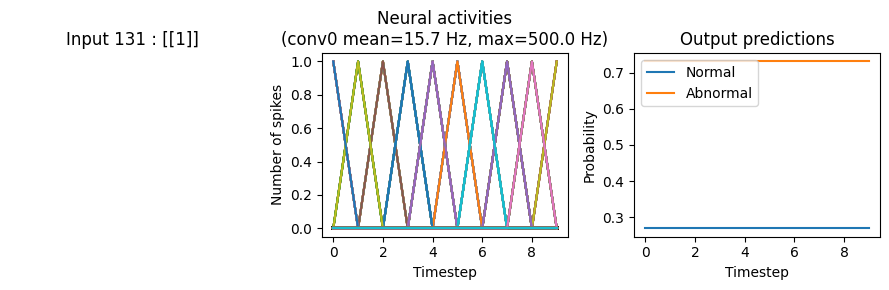

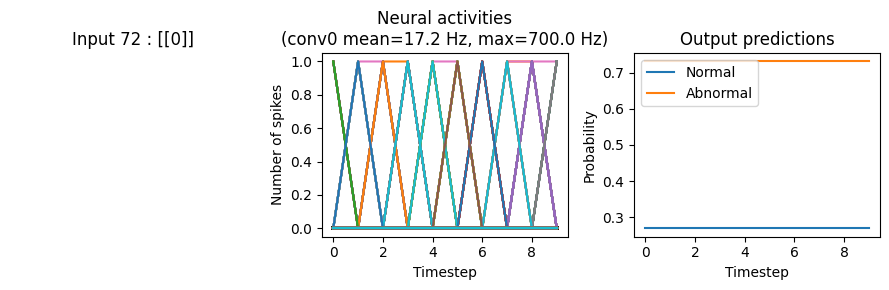

Scale=100
256/256 [==============================] - 6s 20ms/step
Test accuracy: 85.16%
predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


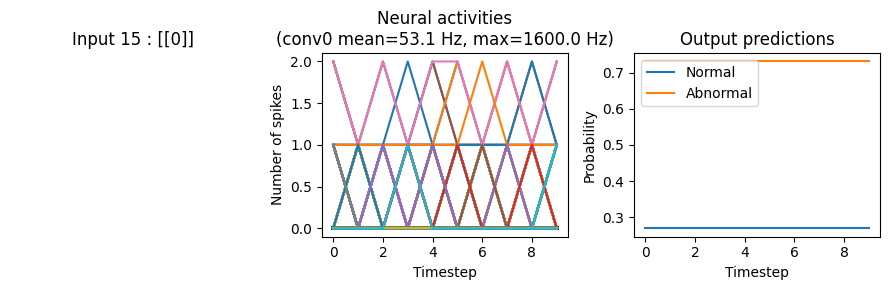

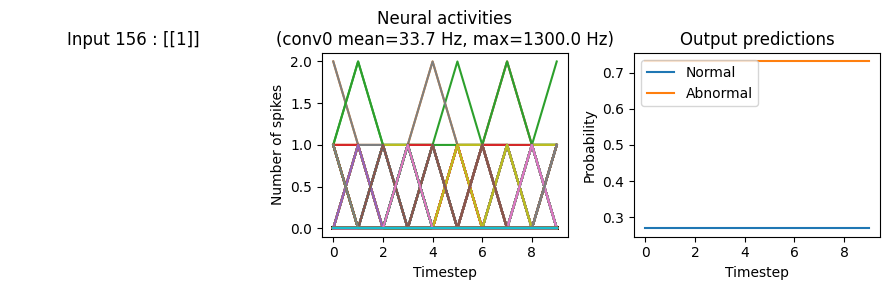

In [17]:
for scale in [20, 50, 100]:
    print(f"Scale={scale}")
    run_network(
        test_batch_inputs, 
        test_batch_outputs, 
        activation=nengo.SpikingRectifiedLinear(),
        scale_firing_rates=scale,
    )
    plt.show()

Scale=200
256/256 [==============================] - 6s 21ms/step
Test accuracy: 85.16%
predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


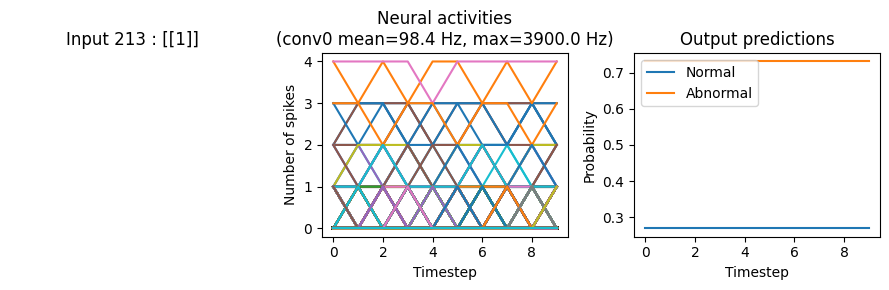

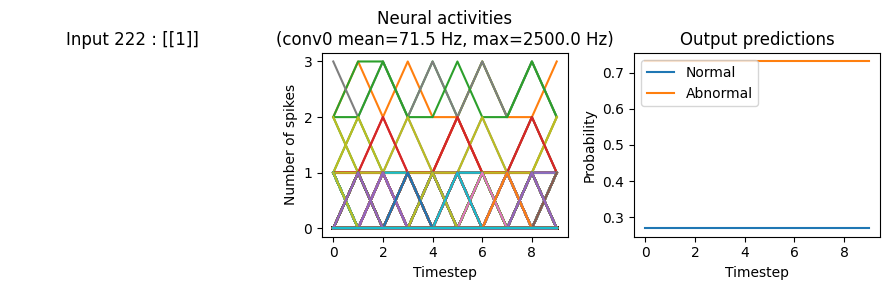

Scale=500
256/256 [==============================] - 6s 21ms/step
Test accuracy: 85.16%
predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


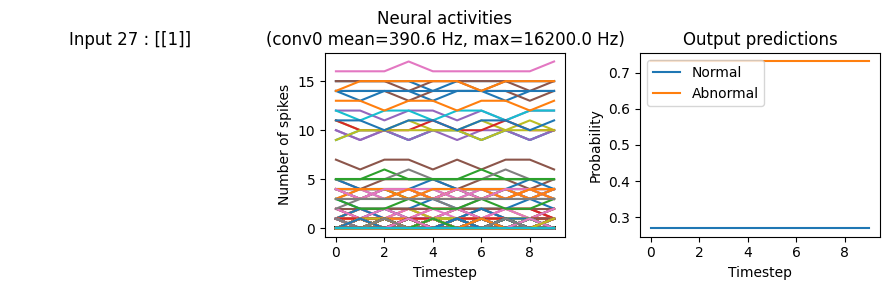

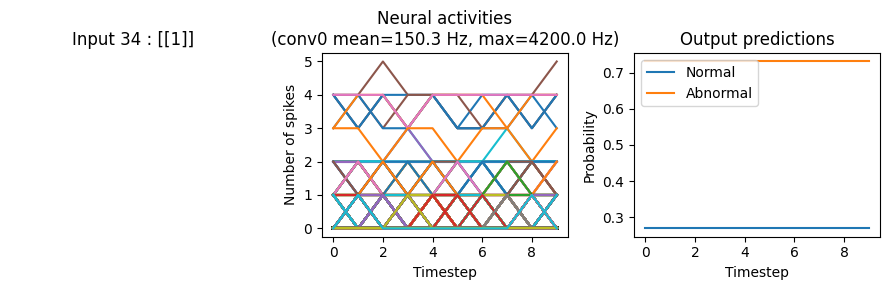

Scale=700
256/256 [==============================] - 5s 19ms/step
Test accuracy: 85.16%
predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


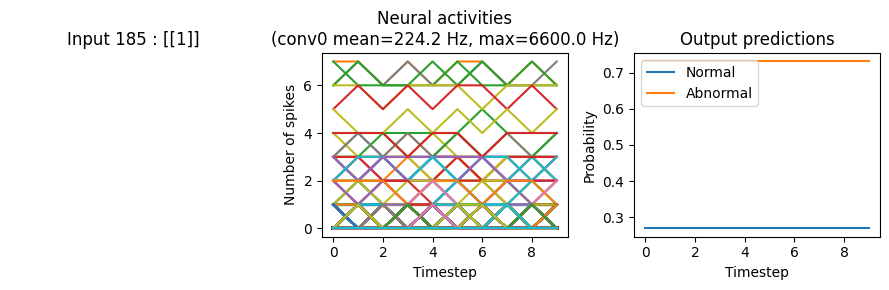

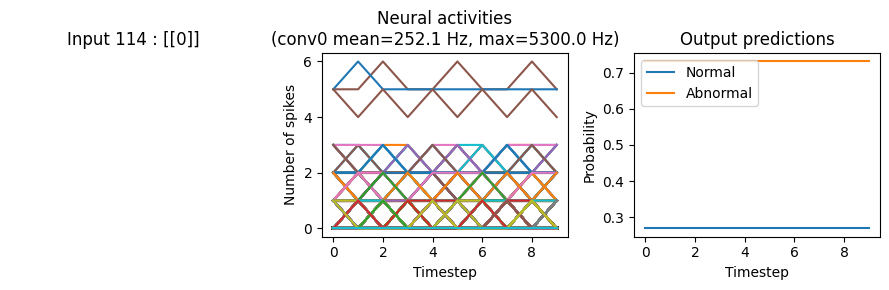

In [18]:
for scale in [200, 500, 700]:
    print(f"Scale={scale}")
    run_network(
        test_batch_inputs, 
        test_batch_outputs, 
        activation=nengo.SpikingRectifiedLinear(),
        scale_firing_rates=scale,
        synapse=0.01,
    )
    plt.show()

256/256 [==============================] - 5s 19ms/step
Test accuracy: 85.16%
predictions [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


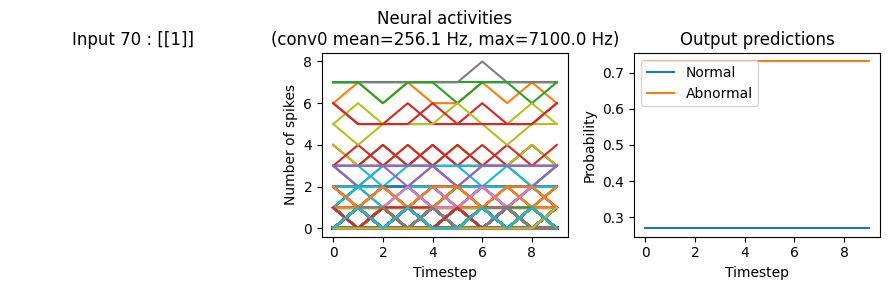

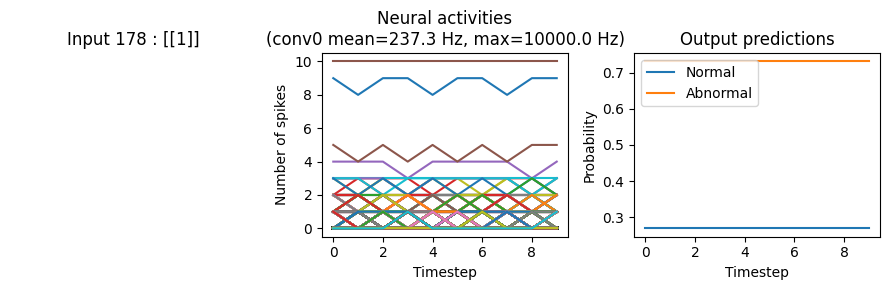

In [19]:
run_network(
    test_batch_inputs, 
    test_batch_outputs, 
    activation=nengo.SpikingRectifiedLinear(),
    scale_firing_rates=1000, 
    n_steps=10,
)